## 統計學習與深度學習 Homework 1
#### 財金四 B07703093 翁如萱
---

### 使用套件

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt  
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

np.set_printoptions(suppress=True)

### 常用函數 - 損失函數
可選擇以 RMSE 或是 MAE 作為衡量指標

In [2]:
def cal_loss(pred, actual, mode = 'RMSE'):
    """mode can be RMSE or MAE"""
    if (mode == 'RMSE'):
        return np.sqrt(np.mean((actual - pred)**2))
        
    elif (mode == 'MAE'):
        return np.mean(np.abs(actual - pred))
    
    else:
        return "mode can only be MAE or MASE"

---
### 第一題 [myknn_regressor]

#### Q1.1

本題目的為根據題目所提供的架構，手刻一個命名為 myknn_regressor 的 knn 模型。

In [3]:
class myknn_regressor():
    def __init__(self, n_neighbors = 10, mean_type = "equal_weight"):
        """mean_type can be equal_weight or remove_outliers.
           equal_weight use the same weight for all neighbors.
           remove_outliers remove neighbors out in [Q1 - 1.5 IQR, Q3 + 1.5IQR].
        """
        self.n_neighbors = n_neighbors
        self.mean_type = mean_type

    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def predict(self, x_test):
        """use remove_outliers only if k>=10"""
        # 只要 k < 10, 一律使用 equal_weights 模式
        if (self.n_neighbors < 10 and self.mean_type == "remove_outliers"):
            self.mean_type = "equal_weights"
        
        # 用以存放最後的預測結果
        y_pred = []
        
        # 開始預測各筆資料
        for testData in x_test:
            # 計算出與 train data 個資料之距離, 並將距離、索引值、y值合併為一個 tuple list
            dist = np.sqrt(np.sum((self.x_train - testData)**2, axis = 1)).reshape(-1, 1) 
            idx = np.arange(self.x_train.shape[0]).reshape(-1, 1) 
            y = self.y_train.reshape(-1, 1)
            
            idxDistY = np.concatenate((idx, dist, y), axis = 1)            
            idy_tuple = np.array(list(map(tuple, idxDistY)), dtype = np.dtype([('idx', int), ('dist', float), ('y', int)]))
            
            # 進行排序以後, 選出前 k 筆的資料。
            selectedIdx = np.argsort(idy_tuple, order = ('dist', 'idx'))[:self.n_neighbors]
            selected = idxDistY[selectedIdx]
            
            # 假如選擇的模式是 remove_outliers, 則需要將極端值移除
            if (self.mean_type == "remove_outliers"):
                # 計算上下界
                q1 = np.percentile(selected[:, -1], 25)
                q3 = np.percentile(selected[:, -1], 75)
                iqr = q3 - q1
                upper = q3 + 1.5 * iqr
                lower = q1 - 1.5 * iqr
                
                # 僅保留 y 未過界的觀測值
                selected = selected[((selected[:,-1] <= upper) & (selected[:, -1] >= lower))]
            
            # 計算所有選擇點的 y 的平均值, 作為預測結果
            pre = np.mean(selected[:, -1])
            
            # 紀錄預測結果
            y_pred.append(pre)
        
        y_pred = np.array(y_pred)
        
        return y_pred

```步驟說明```

**__init__**
- 引數初始化，包含 k 值的設定，還有在計算平均值以前是否需要先移除極端值。

**fit**
- 設定訓練集資料 (X_train, Y_train)

**predict**
- 首先確認是否出現 k < 10 且選擇 remove_outliers 的狀況，若有則直接將模式改為 equal_weights。
- 接著計算各筆測試資料與 X_train 各觀測值之距離 (Euclidean distance)，並將其於訓練集當中的索引值與 y 值合併為一個 tuple list。
- 根據距離與索引值進行遞減排序（當有兩筆資料的距離值相等，則會取索引值較前面者）。
- 取出前 k 筆資料。
- 假設選擇 remove_outliers 模式，則先移除離群值。
- 計算被選擇點的 y 之平均值，即該筆測試資料的預測值。
---

#### Q1.2

匯入特徵值有經過標準化的資料集，並且將模型的 k 設定為 20，模式則設定為 equal_weights。接著進行預測，最後列出前 20 筆預測值還有 RMSE。

```匯入資料```

In [4]:
# Load data
def load_data(doscaling = 1):
    """load data
       doscaling: apply feature scaling or not. 
    """
    with open('msd_data1.pickle', 'rb') as fh1:
        msd_data = pickle.load(fh1)

    if (doscaling == 1):
        xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
        #standardize feature values
        X_train = xscaler.transform(msd_data['X_train'])
        X_test = xscaler.transform(msd_data['X_test'])
    else:
        X_train = msd_data['X_train']
        X_test = msd_data['X_test']

    Y_train = msd_data['Y_train']
    Y_test = msd_data['Y_test']

    return X_train, X_test, Y_train, Y_test

```訓練模型與計算 RMSE```

In [5]:
# 匯入資料 (需要經過標準化)
X_train, X_test, Y_train, Y_test = load_data(doscaling = 1)

# 建立預測模型，使用的 k = 20, 模式則是 equal_weight
myknn = myknn_regressor(20, "equal_weight")
myknn.fit(X_train, Y_train)
y_pred = myknn.predict(X_test)

# 計算 rmse
rmse_equ = cal_loss(y_pred, Y_test, mode = 'RMSE')

In [6]:
# 列印結果
print("k = 20, equal_weights, doscaling")
print("--------------------------------")
print(f"RMSE = {rmse_equ}")
print(f"first 20 predictions: \n{y_pred[:20]}")

k = 20, equal_weights, doscaling
--------------------------------
RMSE = 10.25126451549596
first 20 predictions: 
[1993.35 1993.8  2000.65 1991.5  1992.8  1998.5  1988.1  1991.65 2002.25
 2003.   2000.5  1998.65 1995.55 1997.2  1995.05 1997.4  1992.15 2000.45
 2003.2  1995.75]


```步驟說明```

**匯入資料**
- 直接使用題目提供的 function 匯入資料，由於本題的特徵值須經過標準化，故 doscaling 設定為 1。

**進行預測與計算 RMSE**
- 使用剛才建立完畢的 myknn_regressor，k = 20 並使用 equal_weight 模式。
- 計算 Y_test 與預測結果 y_pred 的 RMSE。
- 最後列印結果

---

#### Q1.3 
匯入特徵值有經過標準化的資料集，並且將模型的 k 設定為 20，模式則設定為 remove_outliers。接著進行預測，最後列出前 20 筆預測值還有 RMSE。

```訓練模型與計算 RMSE```

In [7]:
# 匯入資料
X_train, X_test, Y_train, Y_test = load_data(doscaling = 1)

# 建立預測模型, k = 20, 模式則是 remove_outliers
myknn = myknn_regressor(20, "remove_outliers")
myknn.fit(X_train, Y_train)
y_pred = myknn.predict(X_test)

# 計算 rmse
rmse_out = cal_loss(y_pred, Y_test, mode = 'RMSE')

In [8]:
# 列印結果
print("k = 20, remove_outliers, doscaling")
print("--------------------------------")
print(f"RMSE = {rmse_out}")
print(f"first 20 predictions: \n{y_pred[:20]}")

k = 20, remove_outliers, doscaling
--------------------------------
RMSE = 10.212572466080376
first 20 predictions: 
[1993.35       1993.8        2000.65       1992.73684211 1992.8
 2000.         1988.1        1991.65       2002.25       2003.94736842
 2000.5        2000.94444444 1995.55       1997.2        1998.61111111
 1997.4        1992.15       2003.83333333 2003.2        1995.75      ]


```步驟說明```

**匯入資料**
- 直接使用題目提供的 function 匯入資料，由於本題的特徵值須經過標準化，故 doscaling 設定為 1。

**進行預測與計算 RMSE**
- 使用剛才建立完畢的 myknn_regressor，k = 20 並使用 equal_weight 模式。
- 計算 Y_test 與預測結果 y_pred 的 RMSE。

**列印結果**
- 列印出前 20 筆預測數值與 RMSE。

---
```Q1.2 與 Q1.3 之結果比較```

**RMSE 比較**
- equal_weights: 10.25, remove_outliers: 10.21
- 在本題可以發現到使用 remove_outliers 模式有助於提升模型的準確度（RMSE 較小），換言之就是保留極端值很可能會使得模型準確度降低。
---

### 第二題  [Tuning the Hyper-parameter]

檢視在三種不同情況下（case1: 特徵值標準化，使用 sklearn 套件；case2: 特徵值無須標準化，使用 sklearn 套件；case3: 特徵值標準化，使用 myknn_regressor）不同的 k 值與 RMSE 之間的關係。並且將結果同時呈現於一張圖表中以便於比較。

In [9]:
# 不同的 k 值
kList = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 80, 100, 120, 140, 160, 180, 200]

```case1: doscaling, sklearn```

In [10]:
# 匯入資料
X_train, X_test, Y_train, Y_test = load_data(doscaling = 1)

# 存放各個 k 值下的 rmse 值
rmse_1 = []

# 檢視各個 k 值下的結果
for k in kList:
    # 建立模型
    knn_1 = KNeighborsRegressor(n_neighbors = k)
    knn_1.fit(X_train, Y_train)
    y_pred = knn_1.predict(X_test)

    # 計算 rmse
    rmse = cal_loss(y_pred, Y_test, mode = 'RMSE')
    
    # 紀錄結果
    rmse_1.append(rmse)

```case2: without doscaling, sklearn```

In [11]:
# 匯入資料
X_train, X_test, Y_train, Y_test = load_data(doscaling = 0)

# 存放各個 k 值下的 rmse 值
rmse_2 = []

# 檢視在各個 k 值下的結果
for k in kList:
    # 建立模型
    knn_2 = KNeighborsRegressor(n_neighbors = k)
    knn_2.fit(X_train, Y_train)
    y_pred = knn_2.predict(X_test)

    # 計算 rmse
    rmse = cal_loss(y_pred, Y_test, mode = 'RMSE')
    
    # 紀錄結果
    rmse_2.append(rmse)

```case3: doscaling, myknn_regressor```

In [12]:
# 匯入資料
X_train, X_test, Y_train, Y_test = load_data(doscaling = 1)

# 存放各個 k 值下的 rmse
rmse_3 = []

# 檢視在各個 k 值下的結果
for k in kList:
    # 建立預測模型
    knn_3 = myknn_regressor(k, "remove_outliers")
    knn_3.fit(X_train, Y_train)
    y_pred = knn_3.predict(X_test)

    # 計算 rmse
    rmse = cal_loss(y_pred, Y_test, mode = 'RMSE')
    
    # 紀錄 rmse
    rmse_3.append(rmse)

```繪圖```

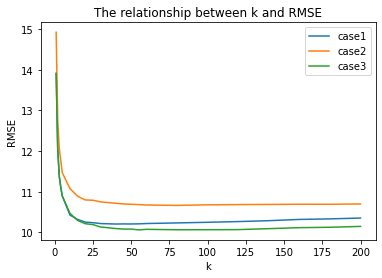

In [13]:
case1, = plt.plot(kList, rmse_1, label = "case1")
case2, = plt.plot(kList, rmse_2, label = "case2")
case3, = plt.plot(kList, rmse_3, label = "case3")

plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(handles = [case1, case2, case3], loc='upper right')
plt.title("The relationship between k and RMSE")
plt.show()

```結果觀察```

**執行速度**
- 使用 sklearn (case1, case2) 的執行速度很明顯的快於使用我們手刻的 myknn_regressor (case3) 之速度。
- 可能原因是我們在於我們手刻的模型是使用 brute method，而 sklearn 有使用特殊的資料結構處理以加快速度；再來就是我的程式碼寫得並不夠有效率。

**RMSE**
- 可以發現到三種情況下的 RMSE 大致上都是隨著 k 的增加而下降；另外大概是在 k = 10, 15 附近開始趨於平緩。
- 在 k 值很小時，三個情況的 RMSE 曲線幾近重疊，而在差不多 k = 10, 15 的點時未經標準化的 case2 開始與其他兩者出現分歧；而 case1 與 case3 則較晚出現分歧，原因在於在 k < 10 時，並無法使用 remove_outliers，因此原則上在 k < 10 時，兩者結果相同。
- 而根據圖表也可以發現到，模型準確度的優劣排序大致上是 case3, case1, case2，也就是說特徵值標準化與移除極端值是有助於提升模型效果的。
---

### 第三題  [Lasso Regression]

### Q3.1
根據題目給定的 $L$ 推導出新的 Coordinate Descent with Soft Thresholding 公式。

```推導```

Calculate the derivative of loss function:

$$
L = \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{w}^T \mathbf{x}_i - w_0)^2 + \lambda [\sum_{j=1}^{M} |w_j|]
$$


$$\frac{\partial L}{\partial w_j}
=\frac{1}{n} \sum_{i=1}^n(y_i-w^Tx_i-w_0)(-x_{i,j})+\lambda sgn(w_j) \\ 
= \frac{1}{n}\sum_{i=1}^n(y_i-w^T_{-j}x_{i,-j}-w_jx_{i,j}-w_0)(-x_{i,j})+\lambda sgn(w_j) \\
= \frac{1}{n}\sum_{i=1}^n(y_i-w^T_{-j}x_{i,-j})(-x_{i,j})
+ \frac{1}{n} w_j \sum_{i=1}^n(x_{i,j}^2)+\lambda sgn(w_j)$$

Use $\tilde {w}$ as the starting value, and solve:
$$\frac{1}{n}\sum_{i=1}^n(y_i-w^T_{-j}x_{i,-j})(-x_{i,j})
+ \frac{1}{n} w_j \sum_{i=1}^n(x_{i,j}^2)+\lambda sgn(w_j) = 0 \\
w_j = \frac{\sum_{i=1}^n(y_i-w^T_{-j}x_{i,-j})x_{i,j}-n \lambda sgn(w_j)}{\sum_{i=1}^nx_{i,j}^2}$$

Hence, if we set $$w_j^* = \frac{\sum_{i=1}^n(y_i-w^T_{-j}x_{i,-j})x_{i,j}}{\sum_{i=1}^nx_{i,j}^2}$$

then:

$$w_j=w_{j}^*-\frac{n\lambda}{\sum_{i=1}^nx_{i,j}^2} ,\: if \: w_j=w_{j}^*-\frac{n\lambda}{\sum_{i=1}^nx_{i,j}^2} > 0$$

$$w_j=w_{j}^*+\frac{n\lambda}{\sum_{i=1}^nx_{i,j}^2} ,\: if \: w_j=w_{j}^*+\frac{n\lambda}{\sum_{i=1}^nx_{i,j}^2} < 0$$

$$w_j=0 ,\: otherwise$$

```說明```

- 本題使用的 $L$ 是沒有 regularized bias term 的。
- 推導出的公式和投影片的基本上大同小異，只差在 $\lambda$ 前的 $n$ 倍數。

---
### Q3.2
本題目標在於依據題目給定的架構建立名為 mylasso 的 lasso 模型。

In [14]:
class mylasso():
    def __init__(self, lamcoef = 0.1, max_iter=1000, tol=1e-6, const_regu = False):
        """lamcoef: the regularization coefficient
           max_iter: maximum number of iteration for model training
           tol: tolerance for the stopping criteria for model training
           const_regu: whether the constant term should be regularized, default to False
           """
        self.lamcoef = lamcoef
        self.max_iter = max_iter
        self.tol = tol
        self.const_regu = const_regu

    def fit(self, x_train, y_train, winit = "ridge", keep_traindata = True, verbose = False):
        """Fit a Lasso model
           x_train: a numpy matrix that contains training features
           y_train: a numpy matrix that contains the label
           winit: how weights are initialized, default to "ridge", ridge regression
           keep_traindata: whether the object is going to keep training data after the training process completed
           verbose: output a lot of message"""

        # 將 x_train 新增截距項, 並且將 y_train 改為行向量
        y_train = y_train.reshape(-1, 1)
        intercept = np.ones((x_train.shape[0], 1))
        x_train = np.concatenate((intercept, x_train), axis = 1)
        
        # soft-threshold formula
        def soft_threshold(alpha, beta):
            if(alpha - beta > 0):
                return alpha - beta
            elif(alpha + beta < 0):
                return alpha + beta
            else:
                return 0
        
        # loss function (即為 L)
        def loss_function(w, reg_w):
            """w 為所有特徵值 (包含截距項) 的權重, 而 reg_w 則是需要正規化的權重 (可能有截距項也可能沒有截距項)"""
            loss = (np.dot((y_train - np.dot(x_train, w)).T, (y_train - np.dot(x_train, w)))) / (2 * x_train.shape[0]) + self.lamcoef * np.sum(np.abs(reg_w))
            
            return loss
        
        # 權重初始化
        omega = np.eye(x_train.shape[1])
        
        if(self.const_regu == False):
            omega[0][0] = 0
        
        # 根據 ridge regression 的解公式, 計算出初始化的 w 
        w = np.linalg.inv(np.dot(x_train.T, x_train) + self.lamcoef * omega).dot(np.dot(x_train.T, y_train)).reshape(-1, 1) 
        wAmount = w.shape[0]
        
        # 在不同情況下, 要進行修正的 w 的起始點以及要進行正規化的 w 
        reg_w = w.copy()
        
        if(self.const_regu):
            startIdx = 0
        else:
            startIdx = 1
            reg_w[0] = 0

        # coordinating descent
        
        # 存取 loss
        loss = []
        # 計算上一次的 Loss
        lastLoss = loss_function(w, reg_w)
        loss.append(lastLoss)
        
        for time in range(self.max_iter):
            # 開始更新各個權重
            for idx in range(startIdx, wAmount):
                # other_w: 排除特定 w 的其他 w, other_x: 少了特定特徵的x, idx_x: 特定的特徵, N: 觀測值數量
                other_w = np.delete(w, idx).reshape(-1, 1)
                other_x = np.delete(x_train, idx, axis = 1)
                idx_x = x_train[:, idx]
                N = x_train.shape[0]
                
                # 代入 soft thresholding 公式
                alpha = np.dot(idx_x, (y_train - np.dot(other_x, other_w))) / np.sum(idx_x**2)
                beta = N * self.lamcoef / np.sum(idx_x**2)
                new_w = soft_threshold(alpha, beta)
                
                # 參數更新
                w[idx] = new_w
                reg_w[idx] = new_w
            
            currentLoss = loss_function(w, reg_w)
            loss.append(currentLoss)
            
            # 判斷 loss 的變化幅度, 以決定是否停止更新權重
            if(abs(currentLoss - lastLoss) < self.tol):
                break
            
            lastLoss = currentLoss
        
        # 得到最終的權重結果以及 training loss
        self.w = w
        self.trainLoss = min(loss)
        
        # 關於是否保留 train data
        if (keep_traindata):
            self.x_train = x_train
            self.y_train = y_train
        
        # 是否列印出權重資訊
        if (verbose):
            print(w.reshape(1, -1))
        
    def predict(self, x_test):
        """Make prediction using trained model"""
        
        # 在 x_test 中加入截距項
        intercept = np.ones((x_test.shape[0], 1))
        x_test = np.concatenate((intercept, x_test), axis = 1)
        
        # 利用 fit 的權重估計結果來得到預測值
        y_pred = np.dot(x_test, self.w).reshape(1,-1)
        
        return y_pred

```步驟說明```

**資料處理**
- 將解釋變數 (X) 加上截距項，而被解釋變數 (Y) 的資料型態改為行向量。

**權重初始化**
- 本題是以 ridge regression 作為權重初始化的方式，以下根據是否有 regularized bias term 分成兩個情況。

- Loss function 與權重之推導：

$$\frac{\partial(Y-X\beta)^T(Y-X\beta) + \lambda \beta^T \Omega \beta}{\partial \beta} = 0, 
\: \Omega = diag(0, 1, 1, ..., 1)\\
 \frac{\partial Y^TY - 2Y^TX\beta + \beta ^TX^TX\beta + \lambda \beta^T \Omega \beta}{\partial \beta} = 0 \\
 0 - 2X^TY + 2X^TX\beta + 2\lambda \Omega \beta = 0 \\
 (X^TX + \lambda \Omega)\beta = X^TY \\
 \beta = (X^TX + \lambda \Omega)^{-1} X^TY
$$

- 若有 bias regularized term: $\Omega = I; \: 否則, \: \Omega = diag(0, 1, 1, ..., 1)$ 

**Coordinate Descent with Soft Thresholding**
- 定義 loss_function：用以計算每次迭代以後的 L 值，以判斷改變幅度。另外參數 w 代表的是包含截距項的所有權重，而 reg_w 則是需要懲罰的權重，假設 const_regu 為 True，則包含截距項，反而則不包含。
- 定義 soft_threshold：函式內容即 Q3.1 的公式。
- Coordinate Descent：開始進行權重更新，若迭代次數超過 max_iter 則停止更新，而一次的迭代定義為更新完所有的權重；另外若 L 的變化幅度小於 tol 也直接停止更新權重。最後，假若 const_regu 設定為 True，則代表著由截距項開始更新權重，反之則是從下一個權重開始更新。
- 迭代完畢以後即可得到最終權重。
- 為方便回答後面小題，最終會有一個 trainLoss 屬性，以得到 training loss。
- 而 w 屬性則是最後使用的權重。

**關於 keep_traindata 與 verbose**
- 若 keep_traindata 為 True，則有 x_train, y_train 的屬性。
- 若 verbose 為 True，則執行完畢時會列印出權重結果。

**得到預測值**
- 將解釋變數加入截距項。
- 傳入欲預測的資料以後，即可利用方才得到的權重進行預測。
---

### Q3.3
載入資料集以後，使用 training data 來計算權重；另外 lamcoef = 0.1，其他參數則使用預設值。最後列出 Training Loss、Training RMSE、Training MAE、截距項、除了截距項以外的權重、非零權重個數。

```匯入資料```

In [15]:
#load the dataset, and create normalized and raw features. 

#Load data
with open('msd_data1.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
#standardize feature values
X_train_sd = xscaler.transform(msd_data['X_train'])
X_test_sd = xscaler.transform(msd_data['X_test'])

#outcome values
Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test']

```訓練模型```

In [16]:
# 擬合模型
mlo = mylasso(lamcoef = 0.1)
mlo.fit(X_train_sd, Y_train)
train_pred = mlo.predict(X_train_sd)

```計算數值並列印結果```

In [17]:
# 計算數值
trainLoss = mlo.trainLoss[0][0]
rmse = cal_loss(train_pred, Y_train, mode = 'RMSE')
mae = cal_loss(train_pred, Y_train, mode = 'MAE')
intercept = mlo.w[0][0]
coef = mlo.w[1:].reshape(1, -1)[0]
nonzeroCount = len(np.where(coef != 0)[0])

print(f"Training Loss: {trainLoss}")
print(f"RMSE in Training Data: {rmse}")
print(f"MAE in Training Data: {mae}")
print(f"Intercept: {intercept}")
print(f"Total number of non-zero coef.: {nonzeroCount}")
print(f"Feature Weights:\n {coef}")

Training Loss: 49.888404109953676
RMSE in Training Data: 9.719499089084632
MAE in Training Data: 6.980898009625434
Intercept: 1998.266
Total number of non-zero coef.: 59
Feature Weights:
 [ 4.6518551  -2.45673153 -1.06195885  0.         -0.34275054 -2.94854329
  0.         -0.39970268 -0.42653866  0.         -0.23498651 -0.39491058
  0.50307719  0.         -0.34207893  0.61674589  0.15722753  0.43489925
  0.43595375  1.12941661  0.40663481  0.          1.77743607  0.
 -0.16842728  0.07833529  0.66391172  0.01297938  0.15350723  0.
 -0.21762074 -0.22189107  0.         -0.0027548  -0.01707674 -0.2599464
  0.          0.28969362  0.34893387  0.         -0.26112569 -0.14488702
 -0.00995271  0.03497723 -0.03984338  0.          0.00299383 -0.17804306
  0.          0.06494382  0.27076506  0.          0.          0.
  0.          0.         -0.63813223  0.23761428 -0.19016387  0.
 -0.18875525  0.         -0.13590668  0.0612754  -0.26619017  0.
  0.          0.         -0.03099184  0.         -

```步驟說明```

**匯入資料**
- 直接使用題目提供的程式碼匯入所需資料

**訓練模型與得到預測值**
- 利用 X_train_sd 與 Y_train 來訓練模型。
- 由於本題需要求得的是 Training RMSE, MAE 等與訓練集資料相關的數值，因此傳入的資料集仍然是 X_train_sd，如此一來才可以得到其預測值 (train_pred)。

**列印結果**
- Training Loss：取得 trainLoss 屬性。
- RMSE, MAE：將 train_pred 與 Y_train 傳入 cal_loss 函式當中，以求得數值。
- Intercept 與 Feauture Weights：取得 w 屬性。
- 非零權重個數：計算 Feature Weights 當中的非零數值個數。

```結果說明```
- 截距項的結果看起來是個合理的年分。
- 可以發現到當迴歸式中加入懲罰項，部分權重可能為變為 0。
---

### Q3.4
使用上一題的模型來計算測試資料的預測值。

```預測結果以列印結果```

In [18]:
# 使用剛才訓練的模型來預測資料, 還有得到 RMSE, MAE
test_pred = mlo.predict(X_test_sd)
rmse = cal_loss(test_pred, Y_test, mode = 'RMSE')
mae = cal_loss(test_pred, Y_test, mode = 'MAE')

# 列印結果
print(f"first five predictions:\n {test_pred[0][:5]}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

first five predictions:
 [1991.93191145 1999.07198637 2001.76293602 1991.30317029 1994.42657933]
Test RMSE: 9.648414790970714
Test MAE: 6.9213859614967586


```步驟說明```
- 原則上和 Q3.3 步驟相同，但是這次 predict 的資料是 test data，也因此計算 RMSE 與 MAE 時，要使用的是 test_pred 還有 Y_test。

```Q3.3 和 Q3.4 之結果比較```
- 無論是以 RMSE 還是 MAE 衡量，測試集的數值皆較訓練集來得小。
- 這個現象感覺有點奇妙，有幾個可能原因：我的模型有錯誤、資料分布問題、參數設定問題。
---

### Q3.5
將不同的 lamcoef 代入模型之中，並且紀錄 Training Loss, Number of Nonzero Weights, Average Weight Size, Training RMSE, Test RMSE 等數值，最後皆結果列表與畫圖。

In [19]:
lambdaList = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]

```建立模型以記錄數值```

In [20]:
trainLoss = []
nonzeroCount = []
avgWeight = []
trainRmse = []
testRmse = []

# 檢視不同 lambda 下的結果 
for l in lambdaList:
    # 訓練模型並得到預測值
    mlo = mylasso(lamcoef = l)
    mlo.fit(X_train_sd, Y_train)
    train_pred = mlo.predict(X_train_sd)
    test_pred = mlo.predict(X_test_sd)
    
    # 計算數值
    loss = mlo.trainLoss[0][0]
    coef = mlo.w[1:].reshape(1, -1)[0]
    nonzero = len(np.where(coef != 0)[0])
    avg = np.mean(np.abs(coef))
    train_rmse = cal_loss(train_pred, Y_train, mode = 'RMSE')
    test_rmse = cal_loss(test_pred, Y_test, mode = 'RMSE')
    
    # 加入串列
    trainLoss.append(loss)
    nonzeroCount.append(nonzero)
    avgWeight.append(avg)
    trainRmse.append(train_rmse)
    testRmse.append(test_rmse)

```整理表格```

In [21]:
# 將結果整理表格
l = pd.DataFrame(lambdaList)
loss = pd.DataFrame(trainLoss)
nonzero = pd.DataFrame(nonzeroCount)
avg = pd.DataFrame(avgWeight)
train_r = pd.DataFrame(trainRmse)
test_r = pd.DataFrame(testRmse)

df = pd.concat([l, loss, nonzero, avg, train_r, test_r], axis = 1)
df.columns = ['$\lambda$', 'Training Loss', '# nonzero weight', 'Avg Weight Size', 'Training RMSE', 'Test RMSE']

df

,$\lambda$,Training Loss,# nonzero weight,Avg Weight Size,Training RMSE,Test RMSE
0,0.0001,46.570461,90,0.470656,9.650516,9.644374
1,0.0005,46.587379,90,0.469507,9.650518,9.644092
2,0.0010,46.608460,90,0.467906,9.650528,9.643539
3,0.0050,46.774657,89,0.455754,9.650862,9.640064
4,0.0100,46.976826,87,0.442903,9.651758,9.636408
5,0.0500,48.417390,76,0.363977,9.672589,9.626434
6,0.1000,49.888404,59,0.294897,9.719499,9.648415
7,0.5000,56.375688,16,0.120031,10.096958,9.999131
8,1.0000,59.889324,4,0.042175,10.591844,10.474621
9,2.0000,61.492131,1,0.004266,11.020374,10.902614


```繪圖```

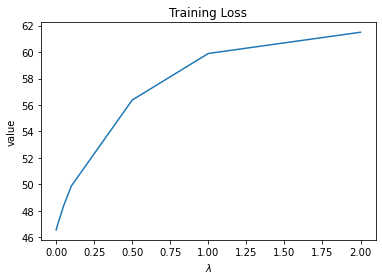

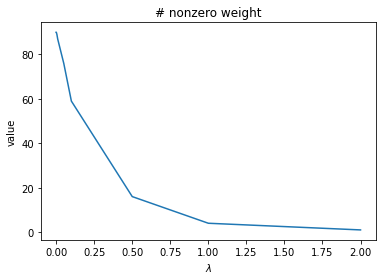

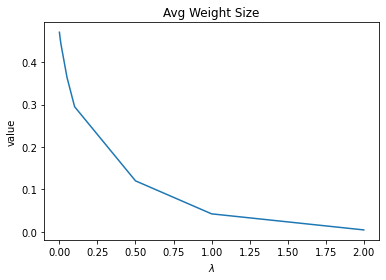

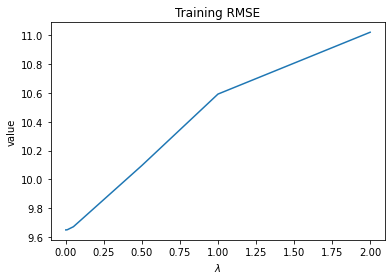

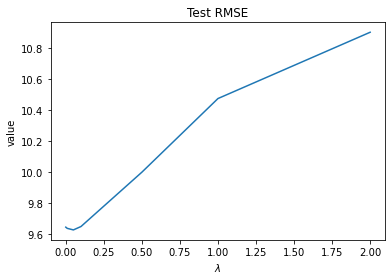

In [22]:
itemList = [trainLoss, nonzeroCount, avgWeight, trainRmse, testRmse]
titleList = ['Training Loss', '# nonzero weight', 'Avg Weight Size', 'Training RMSE', 'Test RMSE']

for item, title in zip(itemList, titleList):
    plt.plot(lambdaList, item)
    plt.xlabel("$\lambda$")
    plt.ylabel("value")
    plt.title(title)
    plt.show()

```結果整理```

**Training Loss**
- 隨著 $\lambda$ 的增大而變大。
- 我認為是合理的結果，因為 loss function 是由 MSE 與 Regularized term 所組成。當 $\lambda$ 值越大時，因為權重值會被壓低甚至為 0，致使模型有較大的偏誤，再來正規項也很容易因 $\lambda$ 的增大而增加。

**Number of Nonzero Weights**
- 隨著 $\lambda$ 的增大而減少。
- 我認為這是合理結果，因為 $\lambda$ 越大時所造成的權重縮小效果越強。另外，lasso regression 的限制式也很容易造成角解的產生，致使很多權重被設定為 0。

**Average Weight Size**
- 隨著 $\lambda$ 的增大而減少。
- 我認為這是合理的結果，原因同上。

**Training RMSE**
- 隨著 $\lambda$ 的增大而變大。
- 我認為這是合理的結果，理由同 Training Loss。因為 $\lambda$ 越大，越容易造成模型有大的偏誤。

**Test RMSE**
- 隨著 $\lambda$ 的增大而變大。
- 不太確定是不是個合理結果。覺得合理的原因同 Training Loss 的理由，覺得可能不合理的原因在於雖然 $\lambda$ 大時偏誤大，但是變異程度也相對較小，而變異小這點應該是有可能降低 Test RMSE 的。感覺比較理想的狀況是看見類似 U 形曲線，或許是因為我的模型設定有問題，或是 $\lambda$ 嘗試的範圍不夠廣。
- 另外，Test RSME 皆小於 Training RMSE。